In [14]:

import math
import torch


def _get_interleave(n):
    def _get_interleave_power_of_2(n):
        start = 2 ** (-(2 ** -(math.log2(n) - 3)))
        ratio = start
        return [start * ratio**i for i in range(n)]

    if math.log2(n).is_integer():
        return _get_interleave_power_of_2(n)
    else:
        closest_power_of_2 = 2 ** math.floor(math.log2(n))
        return (
            _get_interleave_power_of_2(closest_power_of_2)
            + _get_interleave(2 * closest_power_of_2)[0::2][: n - closest_power_of_2]
        )


def _fill_with_neg_inf(t):
    """FP16-compatible function that fills a tensor with -inf."""
    return t.float().fill_(float("-inf")).type_as(t)


def _buffered_future_mask(tensor, maxpos, alibi, attn_heads):
    _future_mask = torch.triu(_fill_with_neg_inf(torch.zeros([maxpos, maxpos])), 1)
    _future_mask = _future_mask.unsqueeze(0) + alibi
    new_future_mask = _future_mask.to(tensor)
    return new_future_mask[: tensor.shape[0] * attn_heads, :maxpos, :maxpos]


def build_dynamically_alibi_tensor(num_heads, max_pos, train_seq_len=64) -> torch.Tensor:
    """Psuedo code for Dynamic NTK-ALiBi."""

    # dynamic ntk factor according to actual sequence length
    a0 = 1.0
    train_seq_len = train_seq_len
    a = a0 * torch.tensor(max_pos) / train_seq_len  # [batch, 1]
    a = a.masked_fill(a < 1.0, 1.0)  # dynamic step 1: dynamic ntk scaling factor

    scale = a ** (1.0 / (num_heads-1))  # dynamic step 2: coefficient b, for computation convenience
    print(scale)
    closest_power_of_2 = 2 ** math.floor(math.log2(num_heads))
    base = torch.tensor(
        2 ** (-(2 ** -(math.log2(closest_power_of_2) - 3))), dtype=torch.float32
    )
    print(base)
    base = base / scale  # dynamic step 3: divide b to alibi base
    powers = torch.arange(1, 1 + closest_power_of_2, dtype=torch.int32)
    slopes = torch.pow(base, powers)
    slopes = slopes * scale  # dynamic step 4: fix alibi bias m_h by multiplying b

    if closest_power_of_2 != num_heads:  # todo: fix ntk when num_heads is not power of 2
        extra_base = torch.tensor(
            2 ** (-(2 ** -(math.log2(2 * closest_power_of_2) - 3))), dtype=torch.float32
        )
        num_remaining_heads = min(closest_power_of_2, num_heads - closest_power_of_2)
        extra_powers = torch.arange(1, 1 + 2 * num_remaining_heads, 2, dtype=torch.int32)
        slopes = torch.cat([slopes, torch.pow(extra_base, extra_powers)], dim=0)
    return slopes

def _gen_alibi_mask(n_head, max_pos):
    """used in inference only"""
    slopes = torch.Tensor(build_dynamically_alibi_tensor(n_head, max_pos))
    print(slopes)
    alibi = slopes.unsqueeze(1).unsqueeze(1) * torch.arange(max_pos).unsqueeze(0).unsqueeze(0).expand(
        n_head, -1, -1)
    alibi = alibi.view(n_head, 1, max_pos).to(torch.float16)
    print(alibi)
    alibi_mask = torch.triu(
        _fill_with_neg_inf(torch.zeros([max_pos, max_pos])), 1
    )
    print()
    alibi_mask = alibi_mask.unsqueeze(0) + alibi
    return alibi_mask

res =  _gen_alibi_mask(32, 128)

tensor(1.0226)
tensor(0.8409)
tensor([0.8409, 0.6915, 0.5686, 0.4676, 0.3845, 0.3162, 0.2600, 0.2138, 0.1758,
        0.1446, 0.1189, 0.0977, 0.0804, 0.0661, 0.0543, 0.0447, 0.0367, 0.0302,
        0.0248, 0.0204, 0.0168, 0.0138, 0.0114, 0.0093, 0.0077, 0.0063, 0.0052,
        0.0043, 0.0035, 0.0029, 0.0024, 0.0020])
tensor([[[0.0000e+00, 8.4082e-01, 1.6816e+00,  ..., 1.0512e+02,
          1.0594e+02, 1.0681e+02]],

        [[0.0000e+00, 6.9141e-01, 1.3828e+00,  ..., 8.6438e+01,
          8.7125e+01, 8.7812e+01]],

        [[0.0000e+00, 5.6836e-01, 1.1367e+00,  ..., 7.1062e+01,
          7.1625e+01, 7.2188e+01]],

        ...,

        [[0.0000e+00, 2.8877e-03, 5.7755e-03,  ..., 3.6108e-01,
          3.6401e-01, 3.6694e-01]],

        [[0.0000e+00, 2.3746e-03, 4.7493e-03,  ..., 2.9688e-01,
          2.9932e-01, 3.0176e-01]],

        [[0.0000e+00, 1.9531e-03, 3.9062e-03,  ..., 2.4414e-01,
          2.4609e-01, 2.4805e-01]]], dtype=torch.float16)



In [13]:
def _gen_alibi_mask0(n_head, max_pos):
    slopes = torch.Tensor(_get_interleave(n_head))
    print(slopes)
    position_point = torch.arange(max_pos) - max_pos + 1
    position_point = position_point.unsqueeze(0).unsqueeze(0).expand(n_head, -1, -1)
    diag = torch.diag(position_point[0])
    position_point = position_point - diag.unsqueeze(0).unsqueeze(0).transpose(-1, -2)
    alibi = slopes.unsqueeze(1).unsqueeze(1) * position_point
    alibi = alibi.view(n_head, 1, max_pos)
    alibi_mask = torch.triu(_fill_with_neg_inf(torch.zeros([max_pos, max_pos])), 1)
    alibi_mask = alibi_mask.unsqueeze(0) + alibi
    return alibi_mask

res0 =  _gen_alibi_mask0(32, 128)

tensor([0.8409, 0.7071, 0.5946, 0.5000, 0.4204, 0.3536, 0.2973, 0.2500, 0.2102,
        0.1768, 0.1487, 0.1250, 0.1051, 0.0884, 0.0743, 0.0625, 0.0526, 0.0442,
        0.0372, 0.0312, 0.0263, 0.0221, 0.0186, 0.0156, 0.0131, 0.0110, 0.0093,
        0.0078, 0.0066, 0.0055, 0.0046, 0.0039])


In [3]:
res

tensor([[[0.0000e+00,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 7.0703e-01,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 7.0703e-01, 1.4141e+00,  ...,       -inf,
                -inf,       -inf],
         ...,
         [0.0000e+00, 7.0703e-01, 1.4141e+00,  ..., 8.8375e+01,
                -inf,       -inf],
         [0.0000e+00, 7.0703e-01, 1.4141e+00,  ..., 8.8375e+01,
          8.9125e+01,       -inf],
         [0.0000e+00, 7.0703e-01, 1.4141e+00,  ..., 8.8375e+01,
          8.9125e+01, 8.9812e+01]],

        [[0.0000e+00,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 4.7754e-01,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 4.7754e-01, 9.5508e-01,  ...,       -inf,
                -inf,       -inf],
         ...,
         [0.0000e+00, 4.7754e-01, 9.5508e-01,  ..., 5.9688e+01,
               

In [7]:
res0

tensor([[[0.0000e+00,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 7.0711e-01,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 7.0711e-01, 1.4142e+00,  ...,       -inf,
                -inf,       -inf],
         ...,
         [0.0000e+00, 7.0711e-01, 1.4142e+00,  ..., 8.8388e+01,
                -inf,       -inf],
         [0.0000e+00, 7.0711e-01, 1.4142e+00,  ..., 8.8388e+01,
          8.9095e+01,       -inf],
         [0.0000e+00, 7.0711e-01, 1.4142e+00,  ..., 8.8388e+01,
          8.9095e+01, 8.9803e+01]],

        [[0.0000e+00,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 5.0000e-01,       -inf,  ...,       -inf,
                -inf,       -inf],
         [0.0000e+00, 5.0000e-01, 1.0000e+00,  ...,       -inf,
                -inf,       -inf],
         ...,
         [0.0000e+00, 5.0000e-01, 1.0000e+00,  ..., 6.2500e+01,
               

In [18]:
1/(2**(1/4))

0.8408964152537146

In [23]:
0.5946/2**(2/31)

0.5685957573544732

Text(0.5, 0, 'Position')

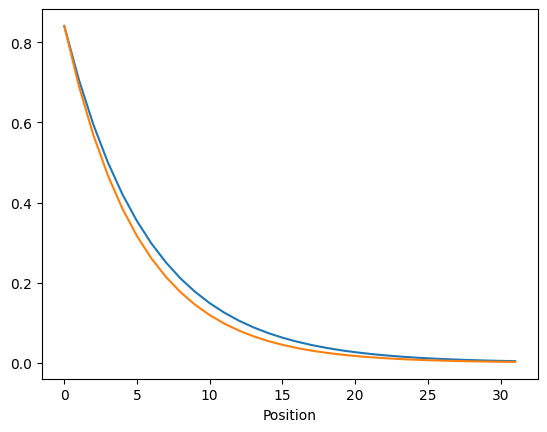

In [25]:
import numpy as np
import matplotlib.pyplot as plt

slope0 = [0.8409, 0.6915, 0.5686, 0.4676, 0.3845, 0.3162, 0.2600, 0.2138, 0.1758,
        0.1446, 0.1189, 0.0977, 0.0804, 0.0661, 0.0543, 0.0447, 0.0367, 0.0302,
        0.0248, 0.0204, 0.0168, 0.0138, 0.0114, 0.0093, 0.0077, 0.0063, 0.0052,
        0.0043, 0.0035, 0.0029, 0.0024, 0.0020]

slope1 = [0.8409, 0.7071, 0.5946, 0.5000, 0.4204, 0.3536, 0.2973, 0.2500, 0.2102,
        0.1768, 0.1487, 0.1250, 0.1051, 0.0884, 0.0743, 0.0625, 0.0526, 0.0442,
        0.0372, 0.0312, 0.0263, 0.0221, 0.0186, 0.0156, 0.0131, 0.0110, 0.0093,
        0.0078, 0.0066, 0.0055, 0.0046, 0.0039]

k = np.arange(0, len(res), 1)
plt.plot(k, slope1)
plt.plot(k, slope0)
# plt.title('i = ' + str(x))
plt.xlabel('Position')
